In [1]:
from operators import BlockMatrixOperator, BlockTriangularPreconditioner
from tunnel_with_subdomains import load_matrices_from_hdf5, load_vectors_from_hdf5

problem_no = 19
path_to_data = f"exported_data/testrun_{problem_no}/"

# loading
A_blocks = load_matrices_from_hdf5(f"{path_to_data}data_as_blocks.h5")
Ptdiagblocks = load_matrices_from_hdf5(f"{path_to_data}data_diag_preco.h5")
Ptblocks = load_matrices_from_hdf5(f"{path_to_data}data_triang_preco.h5")
rhs_u, rhs_p = load_vectors_from_hdf5(f"{path_to_data}data_rhs.h5")  # each rhs_* is a list of ndarrays
sol_u, sol_p = load_vectors_from_hdf5(f"{path_to_data}data_sol.h5")  # each rhs_* is a list of ndarrays

In [2]:
import numpy as np
from numpy.linalg import norm
from scipy.sparse.linalg import gmres, LinearOperator

A_mat = BlockMatrixOperator(A_blocks)
Pt_inv = BlockTriangularPreconditioner(Ptblocks, False)
# Pt_inv = BlockTriangularPreconditioner(Ptdiagblocks, False)

# Define the preconditioned operator
A = LinearOperator(A_mat.shape, matvec=A_mat)
M = LinearOperator(Pt_inv.shape, matvec=Pt_inv)

In [3]:
import numpy as np


def fgmres(A, b, M, maxits=1000, tol=1e-6, x0=None):
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()

    # Initial residual with left preconditioning: r0 = M(b - A*x)
    r0 = M(b - A(x))
    b_norm = np.linalg.norm(M(b)) or 1.0
    res_norm = np.linalg.norm(r0)
    res_hist = [res_norm / b_norm]

    if res_hist[-1] < tol:
        return x, 0, res_hist

    V = np.zeros((n, maxits + 1))
    H = np.zeros((maxits + 1, maxits))

    V[:, 0] = r0 / res_norm
    g = np.zeros(maxits + 1)
    g[0] = res_norm

    for j in range(maxits):
        # Apply A to basis vector
        u = M(A(V[:, j]))  # Left-preconditioned: M*A*v

        # Arnoldi orthogonalization
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i], u)
            u -= H[i, j] * V[:, i]

        H[j + 1, j] = np.linalg.norm(u)

        # Check for happy breakdown
        if H[j + 1, j] < 1e-14:
            break

        V[:, j + 1] = u / H[j + 1, j]

        # Solve small least-squares problem
        y, *_ = np.linalg.lstsq(H[:j + 2, :j + 1], g[:j + 2], rcond=None)
        res_norm = np.linalg.norm(g[:j + 2] - H[:j + 2, :j + 1] @ y)
        res_hist.append(res_norm / b_norm)

        if res_hist[-1] < tol:
            break

    # Explicit final solution reconstruction
    iters = j + 1
    dx = V[:, :iters] @ y
    x += dx

    return x, iters, res_hist

In [ ]:
import numpy as np

def fgmres_deflated(A, b, M, U=None, maxits=1000, tol=1e-6, x0=None):
    n = len(b)
    x0 = np.zeros(n) if x0 is None else x0.copy()

    # Deflation (coarse-space solution)
    if U is not None:
        AU = np.column_stack([A(U[:, i]) for i in range(U.shape[1])])
        AT_AU = np.column_stack([A(AU[:, i]) for i in range(U.shape[1])])
        
        # Coarse operator: Uᵀ Aᵀ A U
        Ac = U.T @ AT_AU if (AT_AU := AT_AU := np.column_stack([A(AU[:, i]) for i in range(U.shape[1])])) is not None else None
        Ac_inv = np.linalg.inv(Ac)

        # Precompute for projector
        def P(v):
            Av = A(v)
            correction = AU @ (Ac_inv @ (U.T @ A(Av)))
            return v - correction
        
        AU = np.column_stack([A(U[:, i]) for i in range(U.shape[1])])
        AT_AU = np.column_stack([A(AU[:, i]) for i in range(U.shape[1])])
        Ac = U.T @ AT_AU
        Ac_inv = np.linalg.inv(Ac)

        def P(v):
            Av = A(v)
            correction = AU @ (Ac @ (U.T @ A(v)))
            return v - correction

        # Coarse solution x_c = U (Uᵀ Aᵀ A U)^{-1} Uᵀ Aᵀ b
        x_c = U @ (np.linalg.solve(Ac, U.T @ A(b)))

    else:
        # No deflation
        x_c = np.zeros(n)
        def P(v):
            return v

    # Initialize
    x0 = np.zeros(n) if x0 is None else x0.copy()
    r0 = P(M(b - A(x0 + x_c)))
    res_norm = np.linalg.norm(r0)
    b_norm = np.linalg.norm(P(M(b))) or 1.0
    res_hist = [res_norm / b_norm]

    if res_hist := res_norm / b_norm < tol:
        return x0 + x_c, 0, res_hist

    V = np.zeros((n, maxits + 1))
    H = np.zeros((maxits + 1, maxits))

    V[:, 0] = r0 = r0 / res_norm
    g = np.zeros(maxits + 1)
    g[0] = res_norm

    for j in range(maxits):
        # Arnoldi iteration with deflated operator
        u = P(M(A(V[:, j])))

        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i], u)
            u -= H[i, j] * V[:, i]

        H[j + 1, j] = np.linalg.norm(u)

        if H[j + 1, j] < 1e-14:
            break

        V[:, j + 1] = u / H[j + 1, j]

        # Solve least-squares problem
        y, *_ = np.linalg.lstsq(H[:j + 2, :j + 1], g[:j + 2], rcond=None)
        res_norm = np.linalg.norm(g[:j + 2] - H[:j + 2, :j + 1] @ y)
        res_hist.append(res_norm / b_norm)

        if res_hist[-1] < tol:
            break

    # Final fine-space solution reconstruction
    x_fine = V[:, :j + 1] @ y

    # Final solution (coarse + fine)
    x_final = x0 + x_c + x_fine

    return x_final, j + 1, res_hist


In [10]:
iter_list = []
res_list = []
true_res_list = []
err_list = []
Z = None
Z_list = []
x_sol = None

warm_up = 10
maxit = 8

for index in range(716):
    rhs_vec = np.concatenate([rhs_u[index], rhs_p[index]])
    sol_vec = np.concatenate([sol_u[index], sol_p[index]])

    # Define a callback function to store residuals
    # residuals = []
    # def callback(resid):
    #     residuals.append(resid)

    # if index > 0 and res_list[-1] < 1e-10:
    #     maxit -= 1
    # # Solve the system using GMRES
    # x_sol, info = gmres(A, rhs_vec, M=M, rtol=1e-16, maxiter=maxit, callback=callback, x0=x_sol)
    x_sol, num_iterations, residuals = fgmres_deflated(A, rhs_vec, M, maxits=30, tol=1e-10, U=Z)
    if norm(x_sol) > 0:
        Z_list.append(x_sol)
        Z = np.column_stack(Z_list)
        Z, _ = np.linalg.qr(Z, mode='reduced')
    # Extract number of iterations (info > 0 indicates it stopped at maxit)
    num_iterations = len(residuals)

    iter_list.append(num_iterations)
    res_list.append(norm(M(A(x_sol) - rhs_vec)) / norm(rhs_vec))
    true_res_list.append(norm(M(A(sol_vec) - rhs_vec)) / norm(rhs_vec))
    err_list.append(norm(x_sol - sol_vec) / norm(sol_vec))
    print(f"Index {index}: {iter_list[-1]}, {res_list[-1]}, {err_list[-1]} {true_res_list[-1]}")

Index 0: 1, nan, nan nan


IndexError: list index out of range

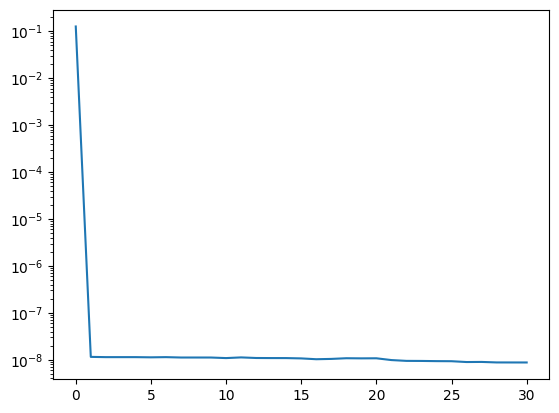

In [8]:
import matplotlib.pyplot as plt
plt.semilogy(residuals)

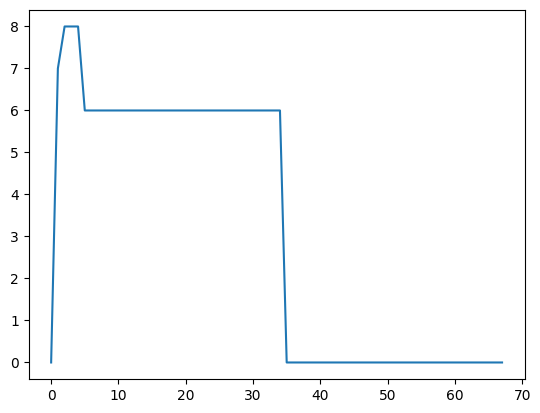

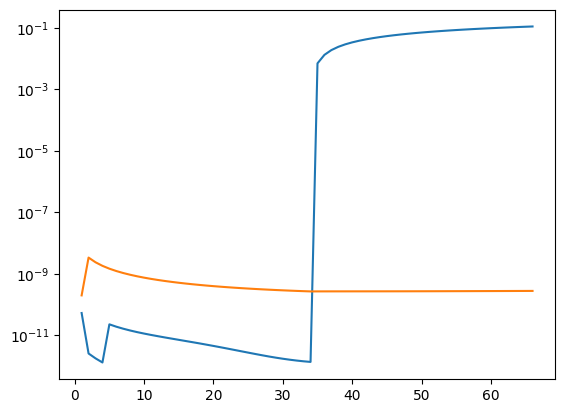

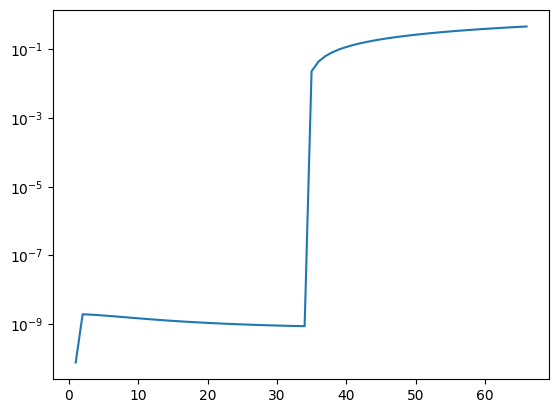

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()

In [ ]:
import numpy as np
from scipy.sparse.linalg import gmres, LinearOperator

iter_list = []
res_list = []
true_res_list = []
err_list = []
Z = None
Z_list = []
x_sol = None

warm_up = 716

for index in range(716):
    rhs_vec = np.concatenate([rhs_u[index], rhs_p[index]])
    sol_vec = np.concatenate([sol_u[index], sol_p[index]])
    if index < warm_up:
        x_sol, iters, res_hist = deflated_fgmres(A_mat, rhs_vec, Pt_inv, maxits=30, tol=1e-14, x0 = x_sol)
    else:
        x_sol, iters, res_hist = deflated_fgmres(A_mat, rhs_vec, Pt_inv, maxits=30, tol=1e-14, Z=Z)

    # Z_list.append(x_sol)
    # if index >= (warm_up - 1):
    #     Z = np.column_stack(Z_list[index - (warm_up - 1):])
    #     Z, _ = np.linalg.qr(Z)

    # if Z is None:
    #     if np.linalg.norm(x_sol) > 0:
    #         Z = x_sol / np.linalg.norm(x_sol)
    #         Z = Z.reshape(-1, 1)
    # else:
    #     Z = extend_orthonormal_basis(Z, x_sol.reshape(-1,1), droptol=1e-6, max_size=100, verbose=True)
    #     if index % 100 == 15:
    #         Z, _ = np.linalg.qr(Z)

    iter_list.append(iters)
    res_list.append(np.linalg.norm(A_mat(x_sol) - rhs_vec)/np.linalg.norm(rhs_vec))
    true_res_list.append(np.linalg.norm(A_mat(sol_vec) - rhs_vec)/np.linalg.norm(rhs_vec))
    err_list.append(np.linalg.norm(x_sol - sol_vec)/np.linalg.norm(sol_vec))
    print(f"Inex {index}: {iters}, {np.linalg.norm(A_mat(x_sol) - rhs_vec)/np.linalg.norm(rhs_vec)}, {np.linalg.norm(x_sol - sol_vec)/np.linalg.norm(sol_vec)} {np.linalg.norm(A_mat(sol_vec) - rhs_vec)/np.linalg.norm(rhs_vec)}")

print(f"Number of iterations: {iters}")
print(f"Relative residual: {res_hist[-1]}")
print(f"Relative error: {np.linalg.norm(x_sol - sol_vec)/np.linalg.norm(sol_vec)}")

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()